In [ ]:
from hydra import initialize, compose
import json
from rdkit import Chem
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.standardize import standardize_mol
from ast import literal_eval
from IPython.display import SVG
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
with initialize(version_base=None, config_path="./conf/filepaths"):
    filepaths = compose(config_name="filepaths")

In [3]:
entries = {}
for i in range(0, 11):
    with open(Path(filepaths.raw_mcsa) / f"entries_{i}.json", "r") as f:
        entries = {**entries, **json.load(f)}

mech_ct = 0
detailed_ct = 0
for id, entry in entries.items():
    mechanisms = entry['reaction']['mechanisms']
    if mechanisms is None:
        continue

    for mech in mechanisms:
        mech_ct += 1
        if mech['is_detailed']:
            detailed_ct += 1

print(f"Total number of mechanisms: {mech_ct}")
print(f"Number of detailed mechanisms: {detailed_ct} ({detailed_ct/mech_ct*100:.2f}%)")
print(f"Total number of entries: {len(entries)}")


Total number of mechanisms: 1166
Number of detailed mechanisms: 887 (76.07%)
Total number of entries: 1003


In [4]:
mech_df = pd.read_csv(Path(filepaths.interim_data) / 'mcsa' / 'mech_labeled_reactions.csv', sep=",")
mech_df["mech_atoms"] = mech_df["mech_atoms"].apply(literal_eval)
n_unique = len(set(mech_df[["entry_id", "mechanism_id"]].apply(tuple, axis=1)))
print(f"{n_unique/detailed_ct*100:.2f}% of detailed mechanisms have been processed")
mech_df.head(10)

83.31% of detailed mechanisms have been processed


entry_id  mechanism_id                                             smarts  \
0         1             1  [CH3:1][CH2:12][CH2:23][C:34](=[O:39])[OH:38]....   
1         2             2  [CH3:1][CH2:12][OH:23].[CH3:7][CH2:6][CH2:5][C...   
2         2             1  [CH3:55][CH2:45][CH2:34][CH2:23][CH2:12][NH2:1...   
3         3             1  [CH3:50][c:1]1[cH:23][nH+:45][cH:34][nH:12]1.[...   
4         4             2  [CH3:56][NH:23][CH:1]([CH3:67])[C:12]([NH2:34]...   
5         4             1  [CH3:1][CH2:12][c:23]1[cH:34][nH:45][cH:56][n:...   
6         5             1  [CH3:1][CH2:12][OH:23].[CH3:31][CH2:2][c:3]1[c...   
7         6             1  [CH3:1][CH2:100][S:111][S:144][CH2:133][CH3:12...   
8         7             2  [CH3:1][CH2:12][c:23]1[cH:34][cH:45][c:56]([OH...   
9         7             1  [CH3:1][CH2:12][c:23]1[cH:34][cH:45][c:56]([OH...   

                                          mech_atoms  \
0                [32, 38, 8, 11, 19, 21, 22, 24, 25]   
1               [37, 38, 42, 17, 18, 20, 23, 58, 61]   
2                [1, 35, 36, 38, 6, 177, 54, 25, 58]   
3  [6, 14, 16, 17, 20, 21, 25, 32, 36, 37, 38, 41...   
4  [15, 20, 28, 32, 41, 49, 52, 53, 54, 55, 59, 6...   
5  [64, 65, 66, 32, 68, 69, 38, 70, 168, 9, 44, 4...   
6                       [33, 34, 7, 40, 115, 23, 25]   
7  [96, 11, 141, 142, 143, 111, 145, 144, 115, 14...   
8  [5, 6, 7, 17, 48, 50, 52, 54, 67, 74, 75, 79, ...   
9  [5, 6, 7, 17, 48, 50, 52, 54, 74, 75, 79, 80, ...   

                        enzyme_name uniprot_id        ec  
0                glutamate racemase     P56868   5.1.1.3  
1          beta-lactamase (Class A)     P62593   3.5.2.6  
2          beta-lactamase (Class A)     P62593   3.5.2.6  
3   NAD(P)H dehydrogenase (quinone)     P15559   1.6.5.2  
4   nitrite reductase (copper type)     P25006   1.7.2.1  
5   nitrite reductase (copper type)     P25006   1.7.2.1  
6                carboxypeptidase D     P08819  3.4.16.6  
7   glutathione-disulfide reductase     P00390   1.8.1.7  
8  isocitrate dehydrogenase (NADP+)     P08200  1.1.1.42  
9  isocitrate dehydrogenase (NADP+)     P08200  1.1.1.42

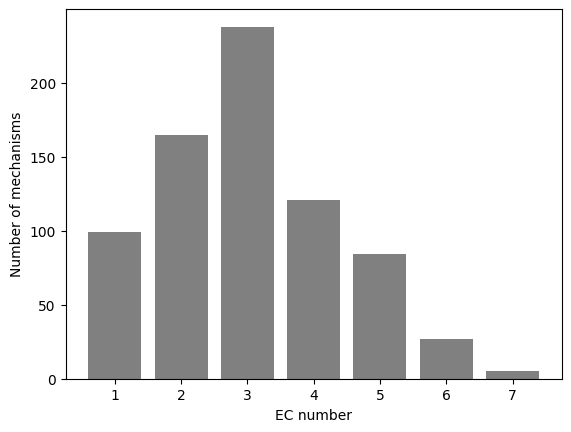

In [6]:
ecs = []
n_digits = 1
for eid in mech_df['entry_id']:
    ecs.append(entries[str(eid)]['reaction']['ec'])

ec_trunc = [elt[:n_digits] for elt in ecs]
ec_counts = Counter(ec_trunc)
ec_counts = sorted(ec_counts.items(), key=lambda x: x[0])

fig, ax = plt.subplots()
x = [i for i in range(len(ec_counts))]
ax.bar(x, [elt[1] for elt in ec_counts], color='gray')
ax.set_xticks(x)
ax.set_xticklabels([elt[0] for elt in ec_counts])
ax.set_xlabel('EC number')
ax.set_ylabel('Number of mechanisms')
plt.show()

In [7]:
def display_mech_labeled_rxn(entry_id: int, de_am: bool = False):
    sma2mol = lambda x : Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmarts(x)))

    # Get the reaction
    smarts = mech_df.loc[mech_df['entry_id'] == entry_id, 'smarts'].iloc[0]

    these_mechs = mech_df.loc[mech_df['entry_id'] == entry_id]
    for _, row in these_mechs.iterrows():
        print(f"Mechanism: #{row['mechanism_id']}")
        smarts = row['smarts']
        lhs = [sma2mol(elt) for elt in smarts.split('>>')[0].split('.')]
        mech_atom_map_nums = row['mech_atoms']

        # Get atoms involved in the reaction
        involved_atoms = []
        for i, mol in enumerate(lhs):
            involved_atoms.append([])

            for atom in mol.GetAtoms():
                if atom.GetAtomMapNum() in mech_atom_map_nums:
                    involved_atoms[i].append(atom.GetIdx())
        
        if de_am:
            for mol in lhs:
                for atom in mol.GetAtoms():
                    atom.SetAtomMapNum(0)

            smarts = '.'.join([Chem.MolToSmiles(mol) for mol in lhs]) + '>>' + smarts.split('>>')[1]
        
        # Display
        display(SVG(draw_reaction(smarts, sub_img_size=(150, 100))))
        for i, rct in enumerate(lhs):
            display(SVG(draw_molecule(rct, size=(300, 200), highlight_atoms=involved_atoms[i], draw_options={"addAtomIndices": False})))

In [29]:
def standardize_de_atom_map(mol: Chem.Mol) -> str:
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
    
    mol = standardize_mol(mol, quiet=True)

    return Chem.MolToSmiles(mol)

Mechanism: #1


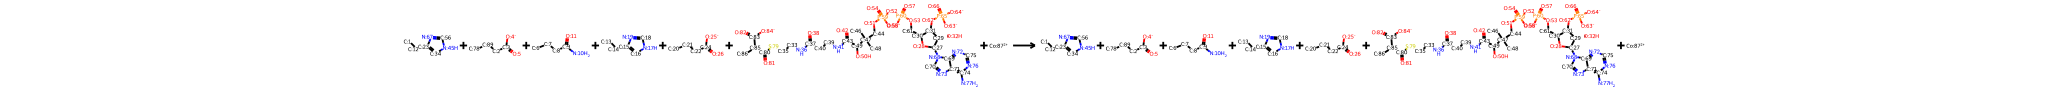

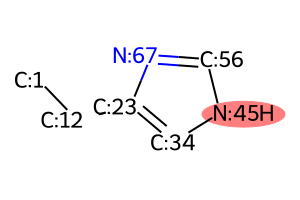

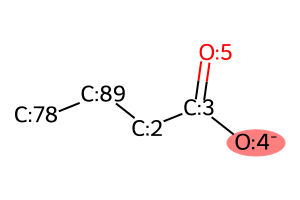

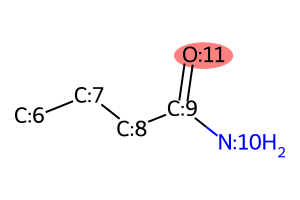

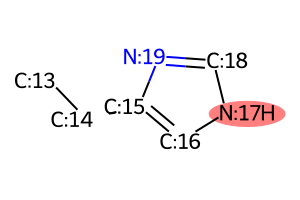

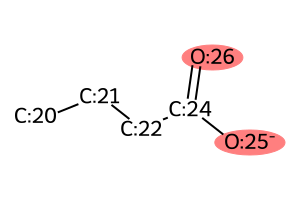

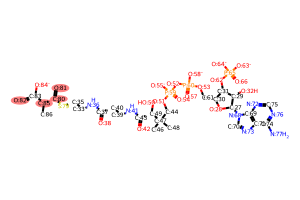

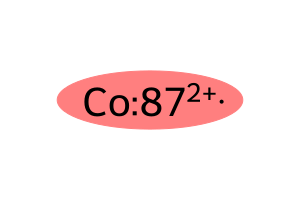

In [8]:
display_mech_labeled_rxn(33)

In [40]:
mech_df.loc[mech_df['entry_id'] ==49]

entry_id  mechanism_id                                             smarts  \
51        49             1  [*:34][C:1](=[O:23])[C:12]([CH3:57])=[O:55].[C...   

                                           mech_atoms  \
51  [1, 3, 356, 38, 41, 42, 12, 44, 46, 238, 52, 2...   

                enzyme_name uniprot_id        ec  
51  histidine decarboxylase     P00862  4.1.1.22

Mechanism: #1


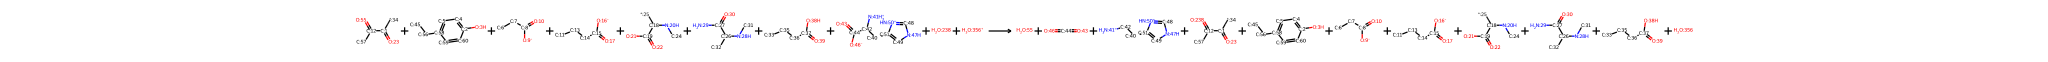

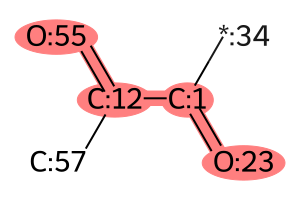

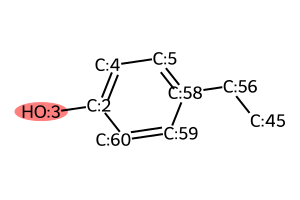

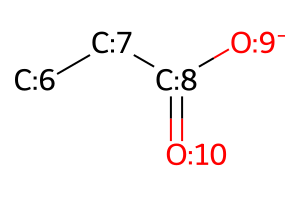

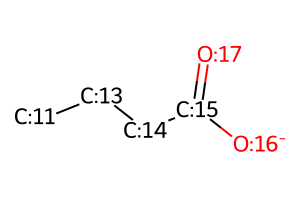

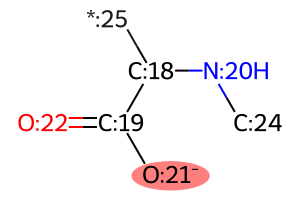

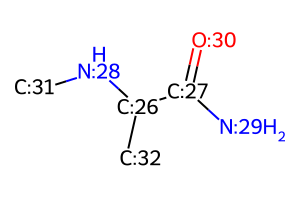

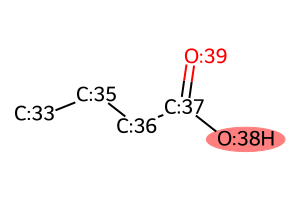

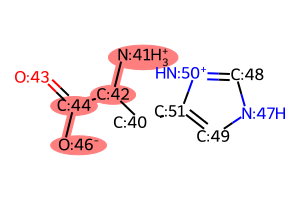

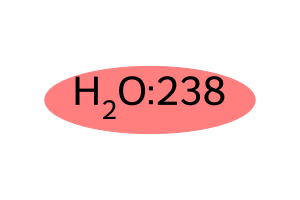

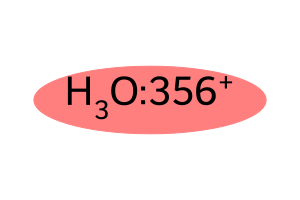

In [38]:
display_mech_labeled_rxn(49)

Mechanism: #1


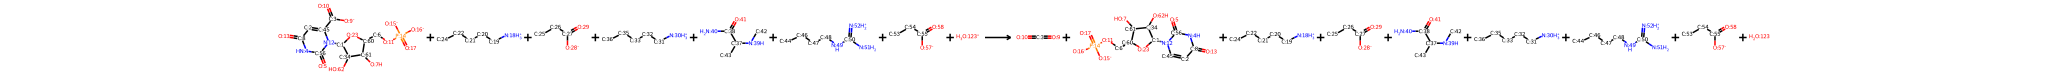

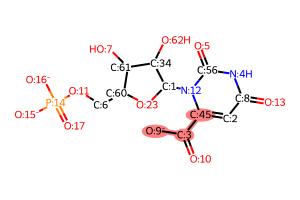

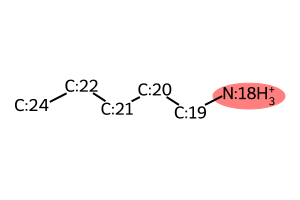

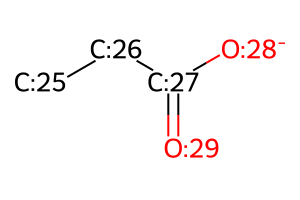

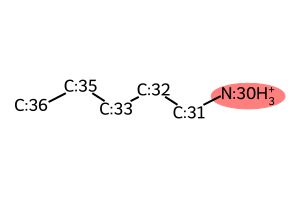

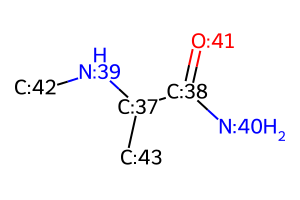

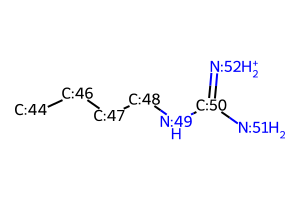

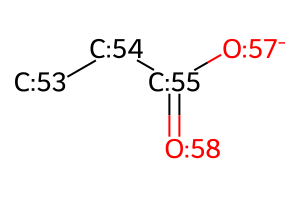

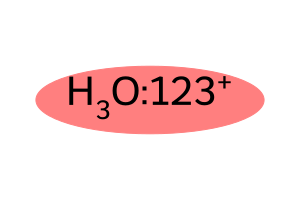

Mechanism: #3


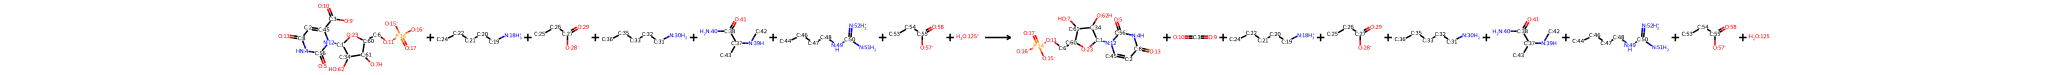

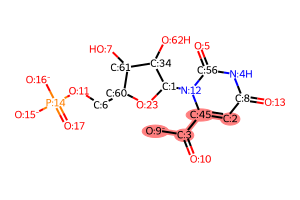

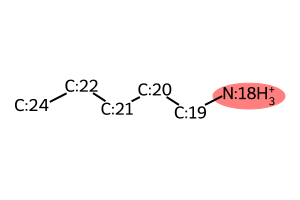

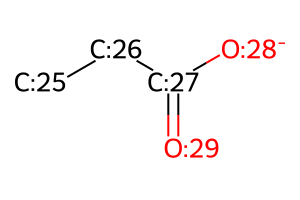

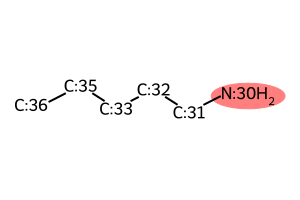

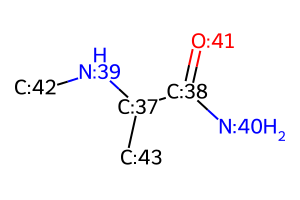

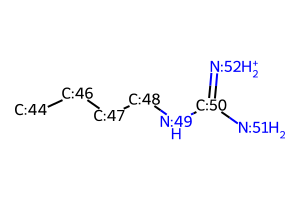

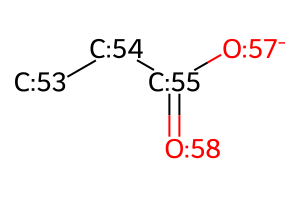

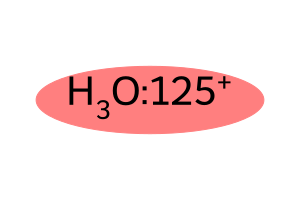

Mechanism: #2


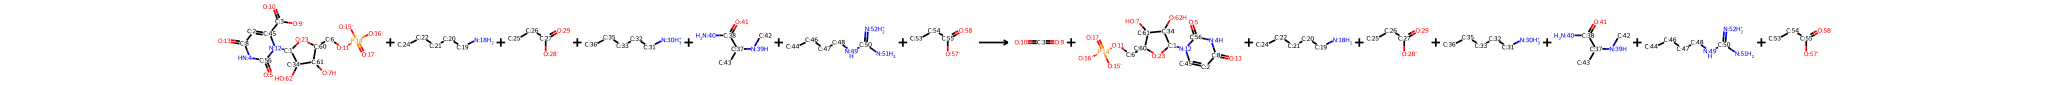

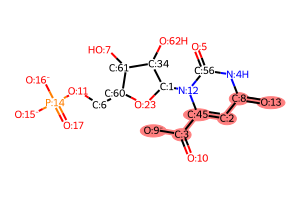

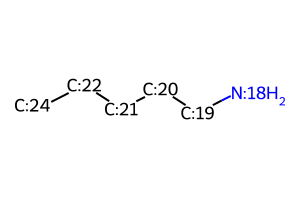

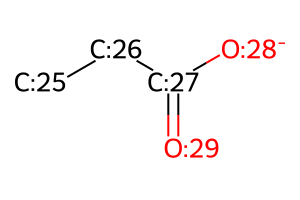

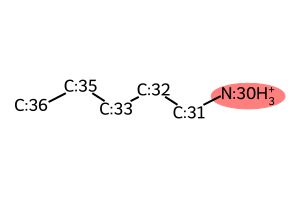

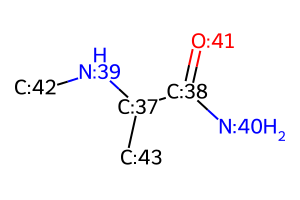

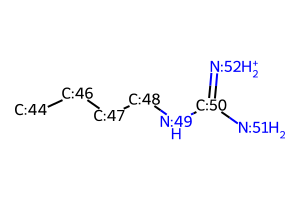

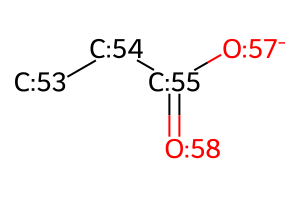

In [11]:
display_mech_labeled_rxn(50)

Mechanism: #1


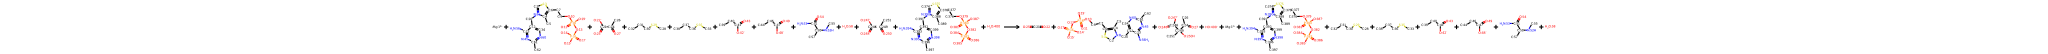

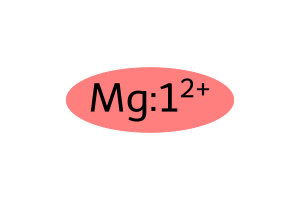

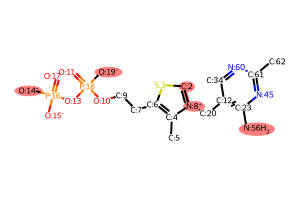

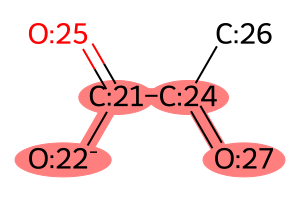

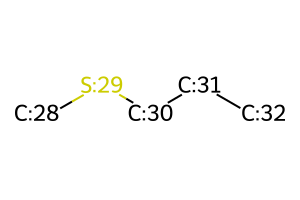

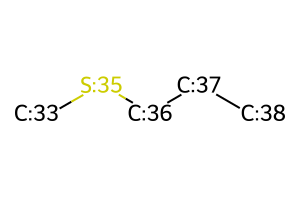

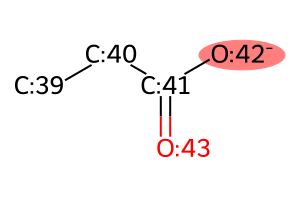

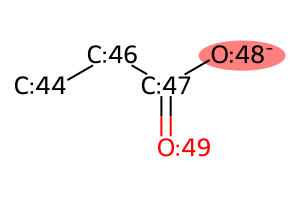

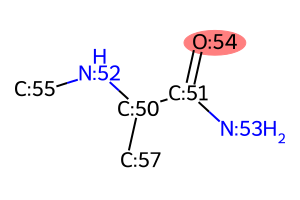

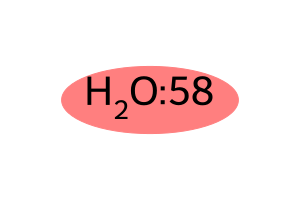

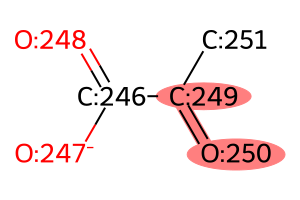

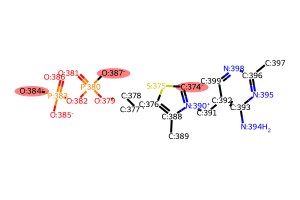

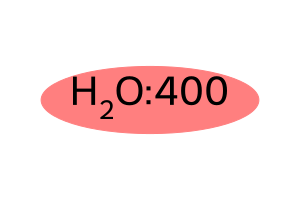

In [12]:
display_mech_labeled_rxn(722)

Mechanism: #1


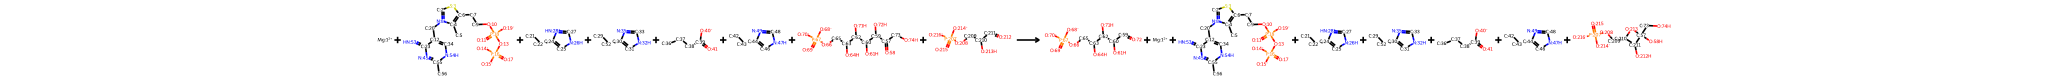

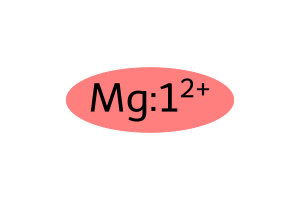

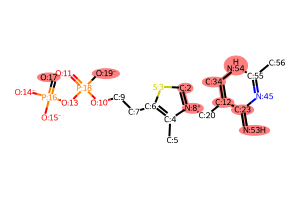

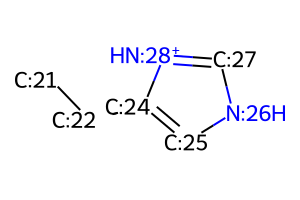

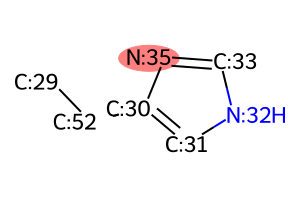

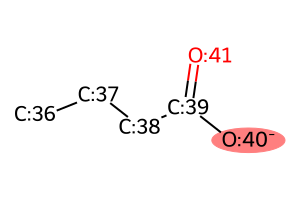

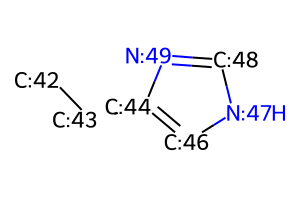

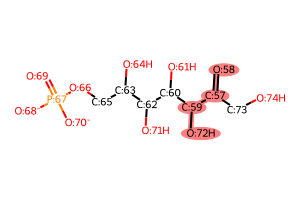

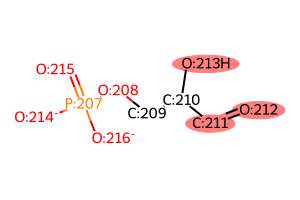

In [13]:
display_mech_labeled_rxn(219)

Mechanism: #2


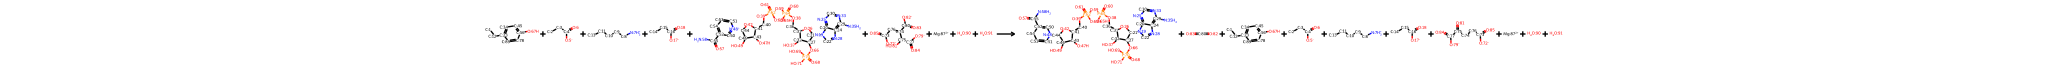

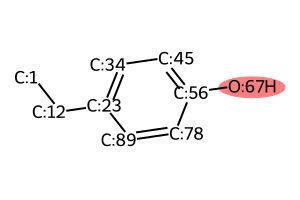

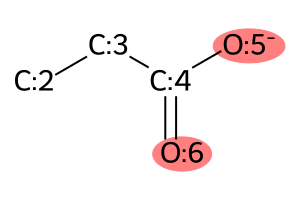

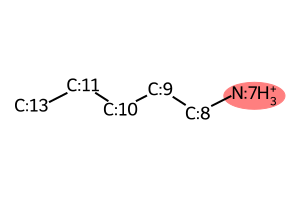

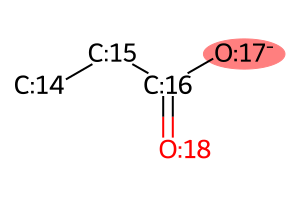

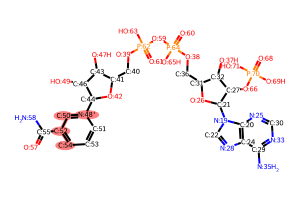

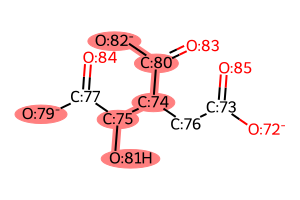

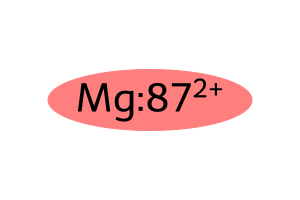

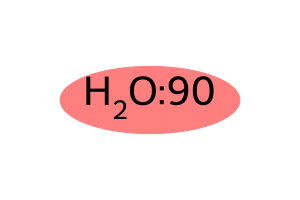

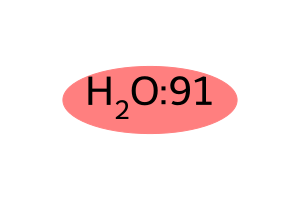

Mechanism: #1


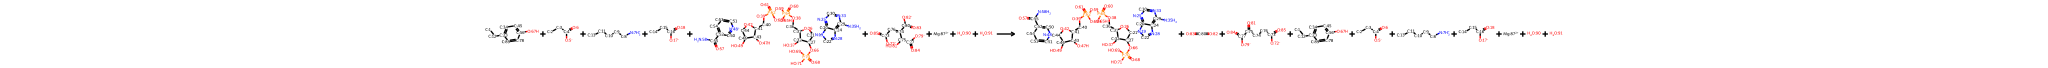

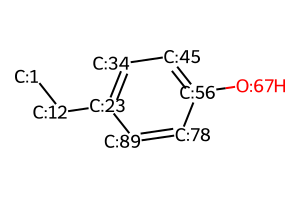

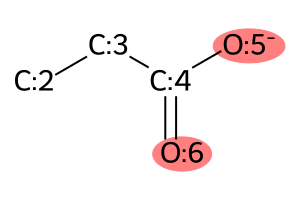

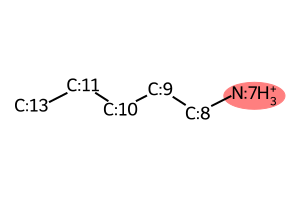

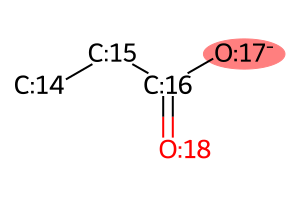

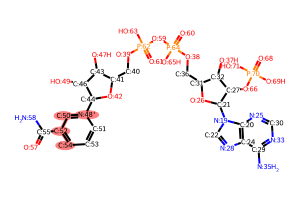

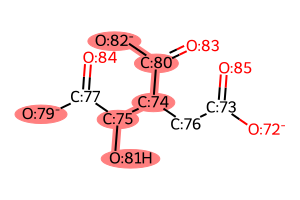

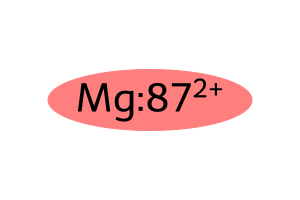

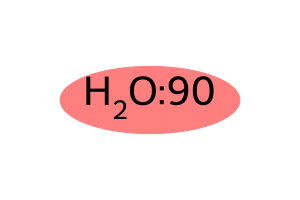

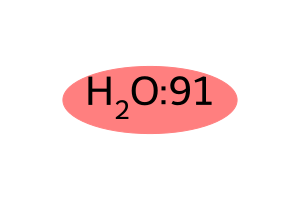

Mechanism: #3


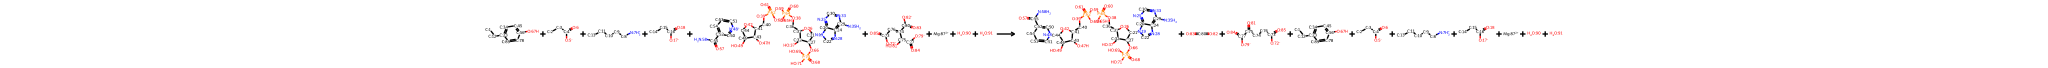

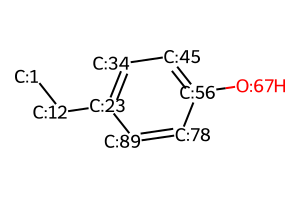

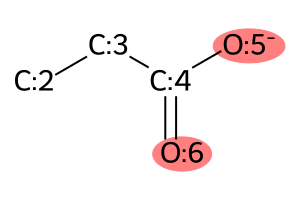

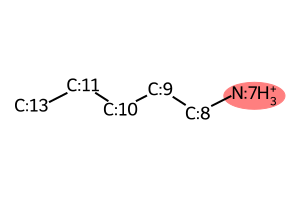

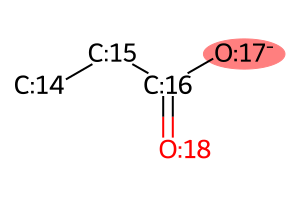

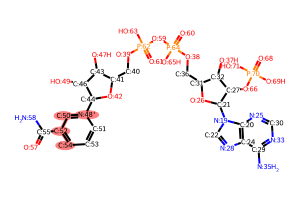

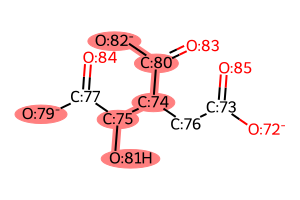

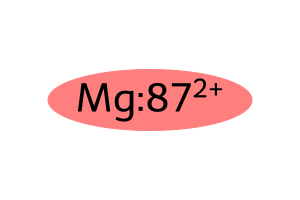

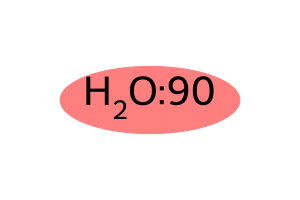

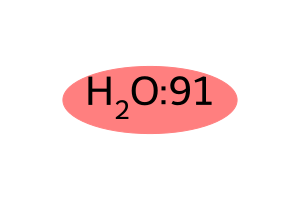

In [14]:
display_mech_labeled_rxn(7)

Mechanism: #2


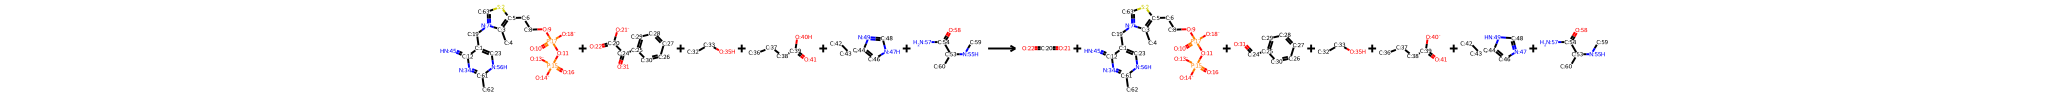

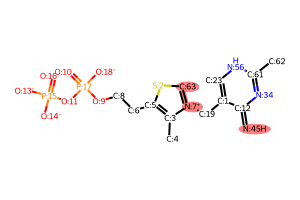

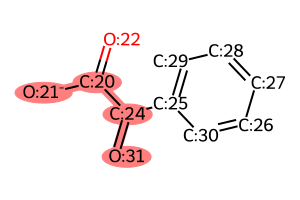

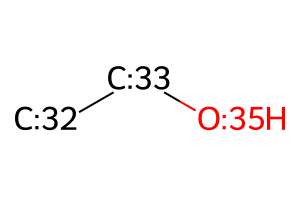

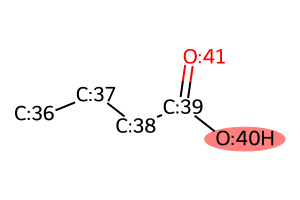

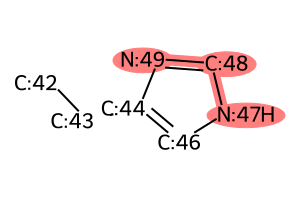

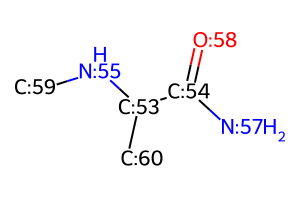

Mechanism: #3


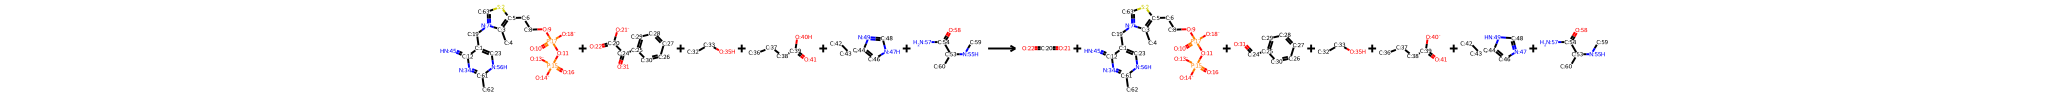

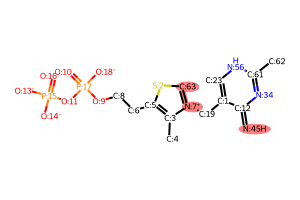

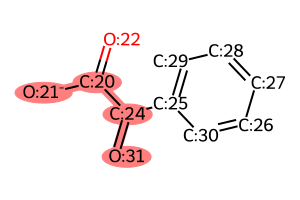

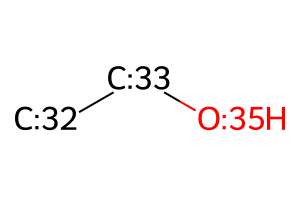

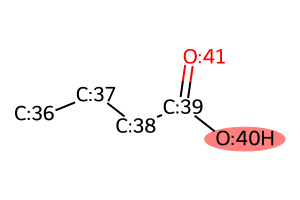

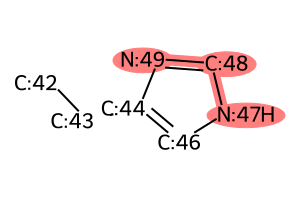

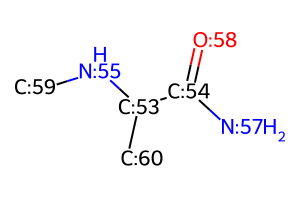

Mechanism: #1


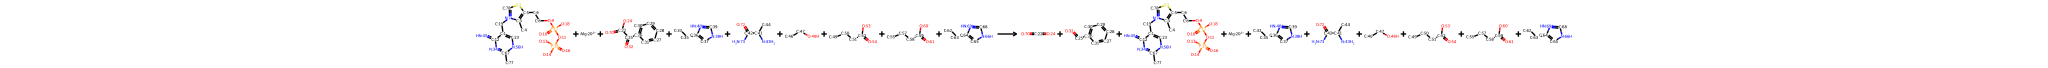

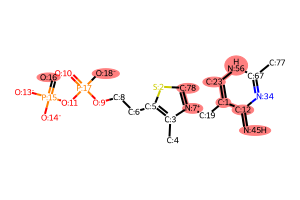

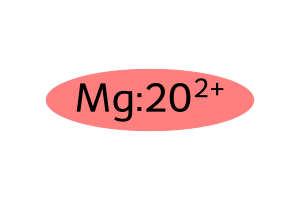

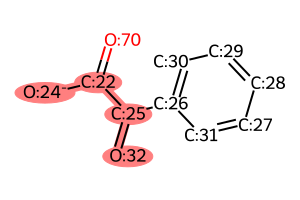

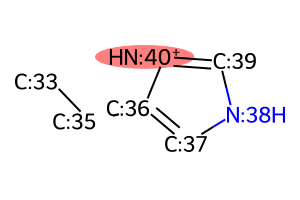

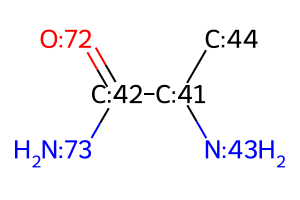

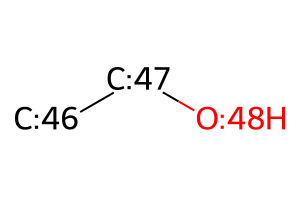

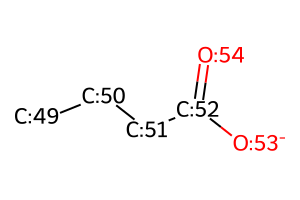

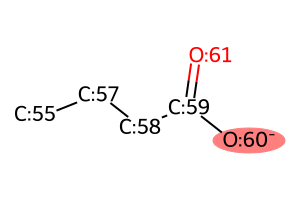

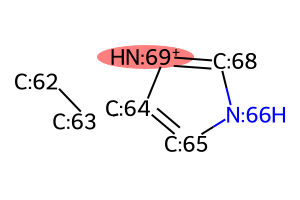

In [15]:
display_mech_labeled_rxn(220)

Mechanism: #1


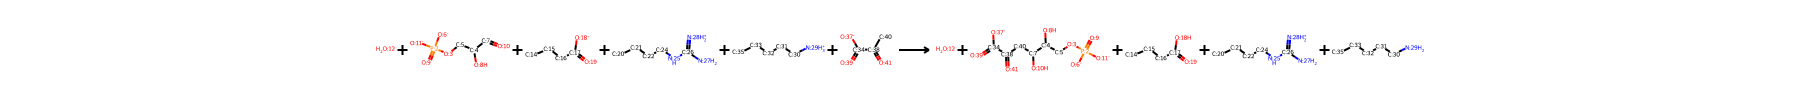

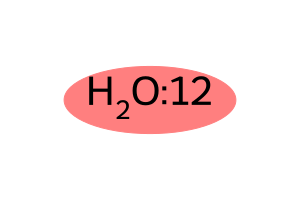

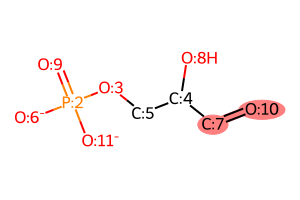

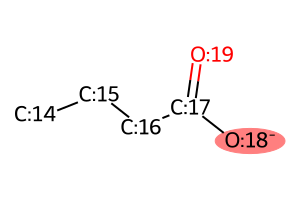

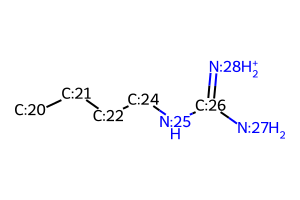

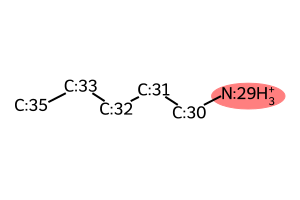

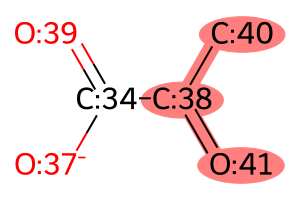

In [16]:
display_mech_labeled_rxn(550)

Mechanism: #1


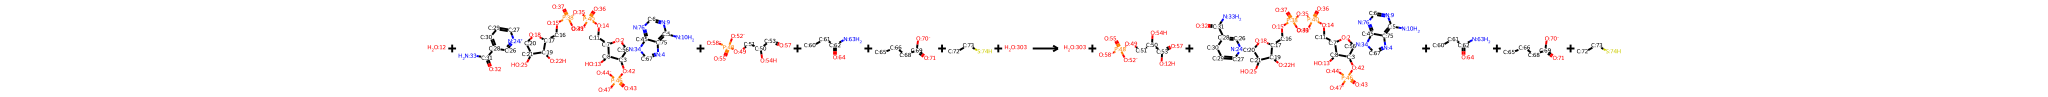

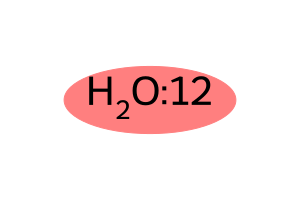

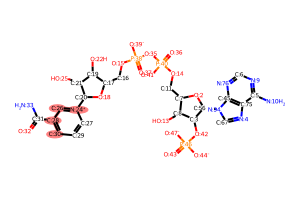

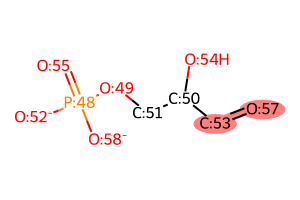

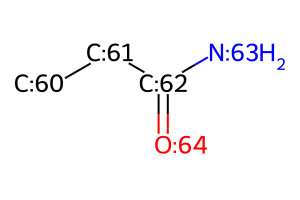

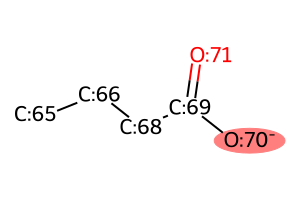

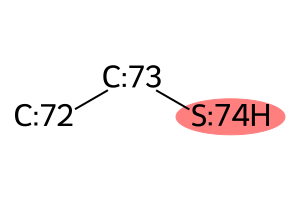

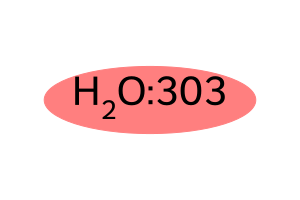

In [17]:
display_mech_labeled_rxn(711)